##### Feature Engineering
Feature Engineering adalah proses dimana kita menerapkan pengetahuan yang kita punya untuk mendapatkan informasi yang lebih dari data yang kita punya. Contohnya dari KTP seseorang, anda sebenarnya dapat mendapatkan domisili, pembuatan KTP, tanggal lahir, usia, dan jenis kelamin. Anda dapat menggolongkan orang-orang dengan kategori yang sama untuk membuat machine learning lebih mudah membedakan ciri orang.

### Import Library yang digunakan

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

### Import Data Set dan Concat Data Frame
Dataset ini adalah dataset Titanic asli yang didapatkan dari Kaggle. Berisi data dari semua orang yang ikut di dalam Kapal Titanic ratusan tahun yang lalu.

Jadi, di dalam dataset ini kita mempunyai target variable/label yaitu Survived. Semua kolom/fitur lain akan digunakan untuk menentukkan apakah penumpang ini selamat/tidak dari kejadian Titanic.

Data Train digunakan untuk melatih model machine learning kita. Data Test nantinya digunakan untuk menebak akurasi model kita di Kaggle.

In [2]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)


df_train = pd.read_csv('../../../Dataset/titanic_train.csv')
df_test = pd.read_csv('../../../Dataset/titanic_test.csv')
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set'

dfs = [df_train, df_test]

In [3]:
df_all.head()

Age Cabin Embarked     Fare  \
0  22.0   NaN        S   7.2500   
1  38.0   C85        C  71.2833   
2  26.0   NaN        S   7.9250   
3  35.0  C123        S  53.1000   
4  35.0   NaN        S   8.0500   

                                                Name  Parch  PassengerId  \
0                            Braund, Mr. Owen Harris      0            1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...      0            2   
2                             Heikkinen, Miss. Laina      0            3   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)      0            4   
4                           Allen, Mr. William Henry      0            5   

   Pclass     Sex  SibSp  Survived            Ticket  
0       3    male      1       0.0         A/5 21171  
1       1  female      1       1.0          PC 17599  
2       3  female      0       1.0  STON/O2. 3101282  
3       1  female      1       1.0            113803  
4       3    male      0       0.0            373450

##### Penjelasan dari dataset
<ul>
    <li>PassengerId adalah id pada row, maka tidak ada pengaruh terhadap target yang dicari</li>
    <li>Survived adalah target yang akan diprediksi, nilai 0 = Not Survived dan nilai 1 = Survived</li>
    <li>Pclass (Passenger Class) adalah kategori level sosial ekonomi penumpang dengan nilai (1, 2 atau 3):
        <ul>
            <li>1 = Upper Class</li>
            <li>2 = Middle Class</li>
            <li>3 = Lower Class</li>
        </ul>
    </li>
    <li>Name, Sex dan Age merupakan data self-explanatory</li>
    <li>SibSp adalah jumlah saudara dari penumpang</li>
    <li>Parch adalah jumlah Orang Tua dan anak dari penumpang</li>
    <li>Ticket adalah jumlah tiket penumpang</li>
    <li>Fare adalah tarif yang di kenakan kepada penumpang</li>
    <li>Cabin adalah nomor kabin penumpang</li>
    <li>Embarked adalah pelabuhan pemberangkatan ada 3 pelabuhan (C, Q atau S):
        <ul>
            <li>C = Cherbourg</li>
            <li>Q = Queenstown</li>
            <li>S = Southampton</li>
        </ul>
    </li>
</ul>



### Exploring Data

In [4]:
print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


### Missing Value dan Contoh data

In [5]:
print(df_train.info(memory_usage=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)None


Kita dapat melihat bahwa ada beberapa data yang kosong di kolom 'Embarked, 'Age', dan 'Cabin'

In [6]:
df_train.head(10)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54.0      0   
7                     Palsson, Master. Gosta Leonard    male   2.0      3   
8  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
9                Nasser, Mrs. Nicholas (Adele Achem)  female  14.0      1   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
5      0            330877   8.4583   NaN        Q  
6      0             17463  51.8625   E46        S  
7      1            349909  21.0750   NaN        S  
8      2            347742  11.1333   NaN        S  
9      0            237736  30.0708   NaN        C

### Mengetahui Korelasi Fitur

In [7]:
df_train_corr = df_train.corr().abs()
print(df_train_corr.to_string())

             PassengerId  Survived    Pclass       Age     SibSp     Parch      Fare
PassengerId     1.000000  0.005007  0.035144  0.036847  0.057527  0.001652  0.012658
Survived        0.005007  1.000000  0.338481  0.077221  0.035322  0.081629  0.257307
Pclass          0.035144  0.338481  1.000000  0.369226  0.083081  0.018443  0.549500
Age             0.036847  0.077221  0.369226  1.000000  0.308247  0.189119  0.096067
SibSp           0.057527  0.035322  0.083081  0.308247  1.000000  0.414838  0.159651
Parch           0.001652  0.081629  0.018443  0.189119  0.414838  1.000000  0.216225
Fare            0.012658  0.257307  0.549500  0.096067  0.159651  0.216225  1.000000


##### Membaca hasil korelasi fitur
Apabila Anda melihat table ini Anda akan mengetahui korelasi antar kolom. Korelasi dapat ditentukan dengan mendekati nilai 1 untuk korelasi positive dan nilai -1 untuk korelasi terbalik.

Pada data ini dapat dilihat bahwa target variable kita Survived sangat besar korelasinya dengan Pclass dan Fare. Sedangkan Age sangat berkaitan dengan Pclass, Sibling Spouse (SibSp), Parent Children (Parch).

Dapat diasumsikan bahwa kebanyakan orang yang selamat adalah orang dengan PClass atas dan Tuanya umur seseorang dapat dikatakan dia akan membawa saudara/orang tua/anak/pasangan.

Dan Fare (harga) tentu saja berkaitan dengan Pclass (kelas penumpang) seorang penumpang.

### Mengenali missing data dari kolom

In [8]:
def display_missing(df):
    for col in df.columns.tolist():
        print('{} column missing values: {}'.format(col,
                                                    df[col].isnull().sum()))
    print('\n')


for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




### Mencari nilai untuk missing value
Untuk mengisi data Age yang kosong, karena kita mengetahui bahwa Umur seseorang berkaitan dengan Kelas penumpangnya, kita dapat mengisinya dengan nilai tengah umur seseorang di dalam kelas tersebut dan berdasar jenis kelaminnya.

Jadi kita lakukan groupby terhadap Jenis Kelamin dan Kelas Penumpang, lalu isi nilai tersebut ke dalam missing value yang ada di dalam data kita.

In [9]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(
            pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df_all['Age'].median()))

# Filling the missing values in Age with the medians of Sex and Pclass groups
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'
                                ])['Age'].apply(lambda x: x.fillna(x.median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


### Mengisi nilai kosong
Kita juga harus mengisi nilai yang hilang untuk kolom Embarked dan Fare.

Untuk Embarked, kebanyakan orang dari Titanic berangkat dari Southampton/S, sehingga kita dapat mengisinya dengan S saja. Ini lebih baik daripada membiarkan datanya kosong.

Untuk Fare, kita tahu bahwa Fare sangat berkaitan dengan Kelas Penumpang, Jumlah Parent/Children, dan Jumlah Sibling/Spouse. Sehingga kita dapat mengisinya dengan nilai tengah dari orang yang berada di grup tersebut.

In [10]:
# Filling the missing values in Embarked with S
df_all['Embarked'] = df_all['Embarked'].fillna('S')

med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# Filling the missing values in Fare with the median Fare of 3rd class along passenger
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

### Exploring data

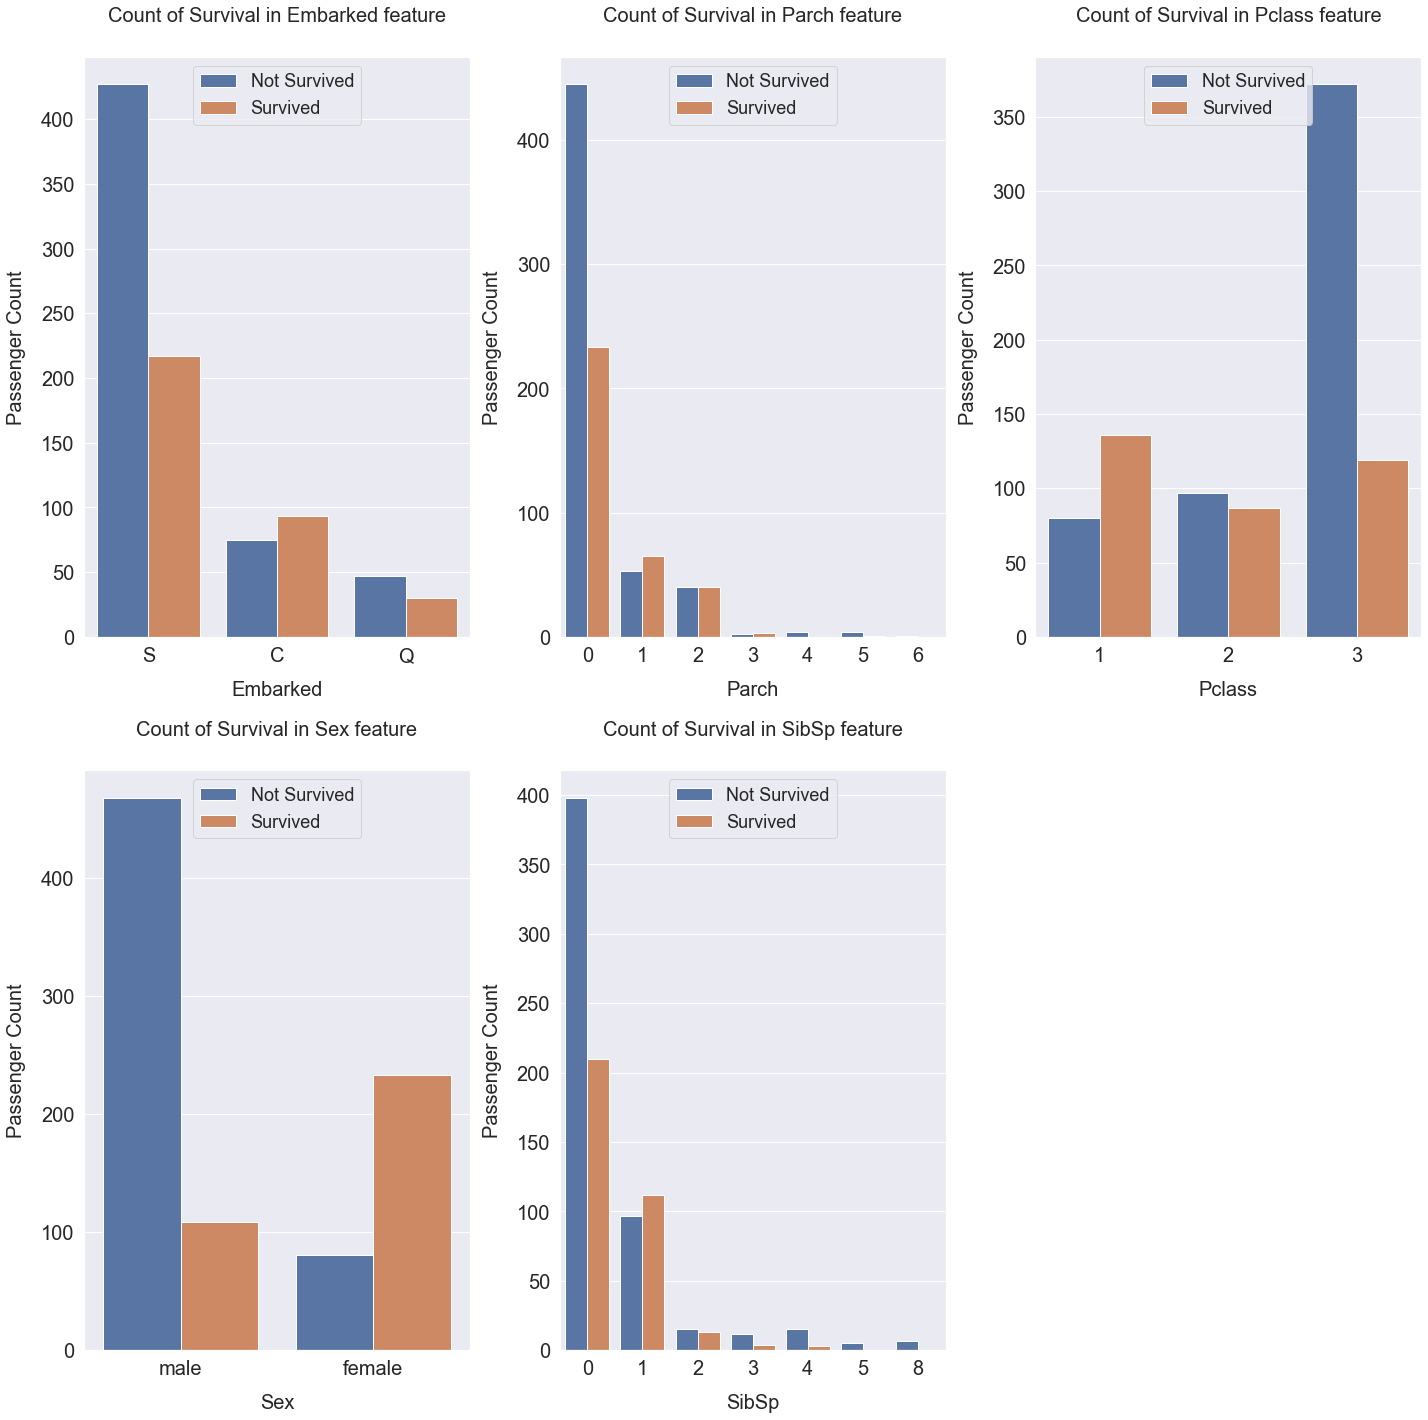

In [11]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=df_train)

    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)

    plt.legend(['Not Survived', 'Survived'],
               loc='upper center',
               prop={'size': 18})
    plt.title('Count of Survival in {} feature'.format(feature),
              size=20,
              y=1.05)

plt.tight_layout()
plt.show()

Dari plot yang dihasikan kita dapat melihat, ternyata penumpang yang berangkat dari **Cherbourg** lebih banyak yang selamat, sedangkan penumpang dari Southampton, hanya setengahnya yang selamat.

Untuk orang yang membawa hanya 1 Parent/Children, lebih banyak yang selamat.

Untuk orang dengan Kelas Penumpang 1, kemungkinan selamatnya jauh lebih tinggi. Dan penumpang dengan Kelas Penumpang 3 hanya sedikit yang selamat.

Dan Orang yang membawa 1 Sibling/Spouse kemungkinan selamatnya jauh lebih besar.

Orang yang membawa 2 Sibling/Spouse kemungkinan selamatnya cukup kecil.

### Exploring data part 2

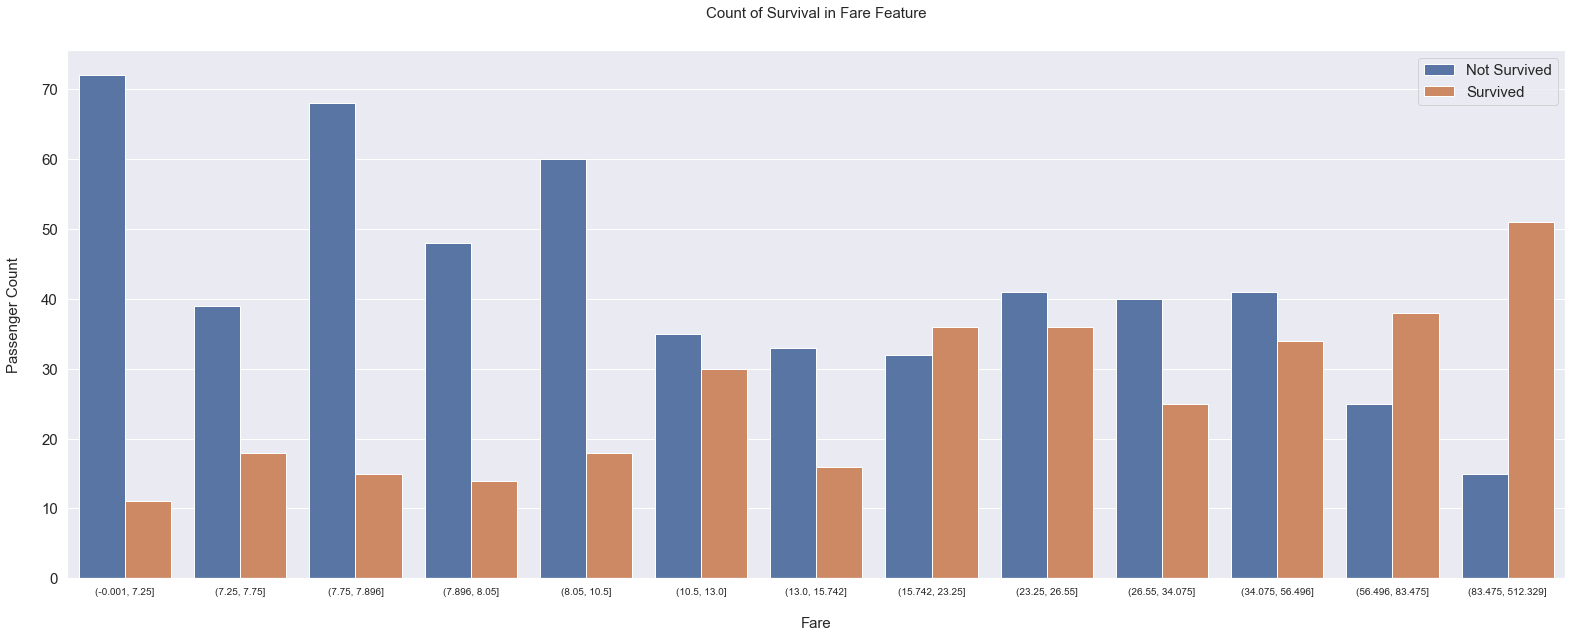

In [12]:
df_all['Fare'] = pd.qcut(df_all['Fare'], 13)

fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=df_all)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)
plt.tight_layout()
plt.show()

Untuk Data Fare dan Age, kita akan membaginya ke dalam beberapa Bin/Group.

Dari fungsi describe sebelumnya, kita tahu bahwa minimal usia yang ada adalah 0.17 tahun dan yang tertua adalah 80 tahun. Sehingga saya rasa membaginya dengan 13 kelompok quantile cukup.

Dan untuk Fare termurah adalah 0 dan termahal adalah 512 (lihat hasil statistik dekriptifnya). Sehingga saya rasa membaginya dengan 10 kelompok quantile cukup.

Perintah yang pertama bermaksud untuk membagi Fare menjadi 13 bagian dengan fungsi qcut().

Dan perintah yang kedua adalah untuk menggambarkan plot group usia terhadap tingkat keselamatan.

Dapat dilihat bahwa semakin mahal harga tiketnya, semakin besar kemungkinan orang itu selamat, dimulai dari harga 56 ke atas.

Tetapi banyak orang yang selamat dimulai dari 10.5 sudah cukup meningkat, kecuali kejadian yang terjadi pada kelompok pemegang tiket berharga 13-15.742.<br><br>

<b><i>Note</i></b>:
Untuk pembagian jumlah bins yang berbeda baik 13 bins untuk "Age" dan 10 bins untuk "Fare" tidak aturan bakunya. Tetapi yang diinginkan dari visualisasi berdasarkan pembagian dengan jumlah bins adalah sebaran datanya. 

Sebagai contoh untuk "Age" yang memiliki range data 0 (min) s/d 80 (max). Untuk itu, awalnya membagi data menjadi 8 bins katakanlah cukup untuk mereprsentasikan sebaran data. Ketika setelah dicek dengan visualisasi sebarannya belum mewakili dan adanya skew. Selanjutnya, kita dapat menaikkan/menurunkan jumlah bins untuk melihat sebaran data berikut. Untuk "Age" ini terpilihlah 13 bins yang cocok untuk mepresentasikan sebaran data. Dengan cara yang sama dapat juga diterapkan untuk "Fare".

Jadi tidak ada aturan baku yang mengatur jumlah bins tersebut.

### Feature Engineering - Part 1
Feature Engineering adalah tentang membuat fitur baru dari fitur yang sudah ada.
Dari sini kita akan membuat beberapa fitur baru yang bertujuan menaikkan akurasi dari model machine learning kita.
Fitur pertama yang kita buat adalah Family_Size, sesuai namanya ini adalah gabungan dari Parent, Children, Sibling, dan Spouse. Lalu kita tambahkan 1 dengan asumsi menghitung diri orang itu juga.<br><br>
Fitur kedua yang kita buat adalah menggabungkan Family_Size dengan groupnya masing-masing tergantung jumlahnya.

Kategorinya adalah seperti berikut.:
<ul>
    <li>Family Size 1 = Alone</li>
    <li>Family Size 2, 3 dan 4 = Small</li>
    <li>Family Size 5 dan 6 = Medium</li>
    <li>Family Size 7, 8 dan 11 = Large</li>
</ul>

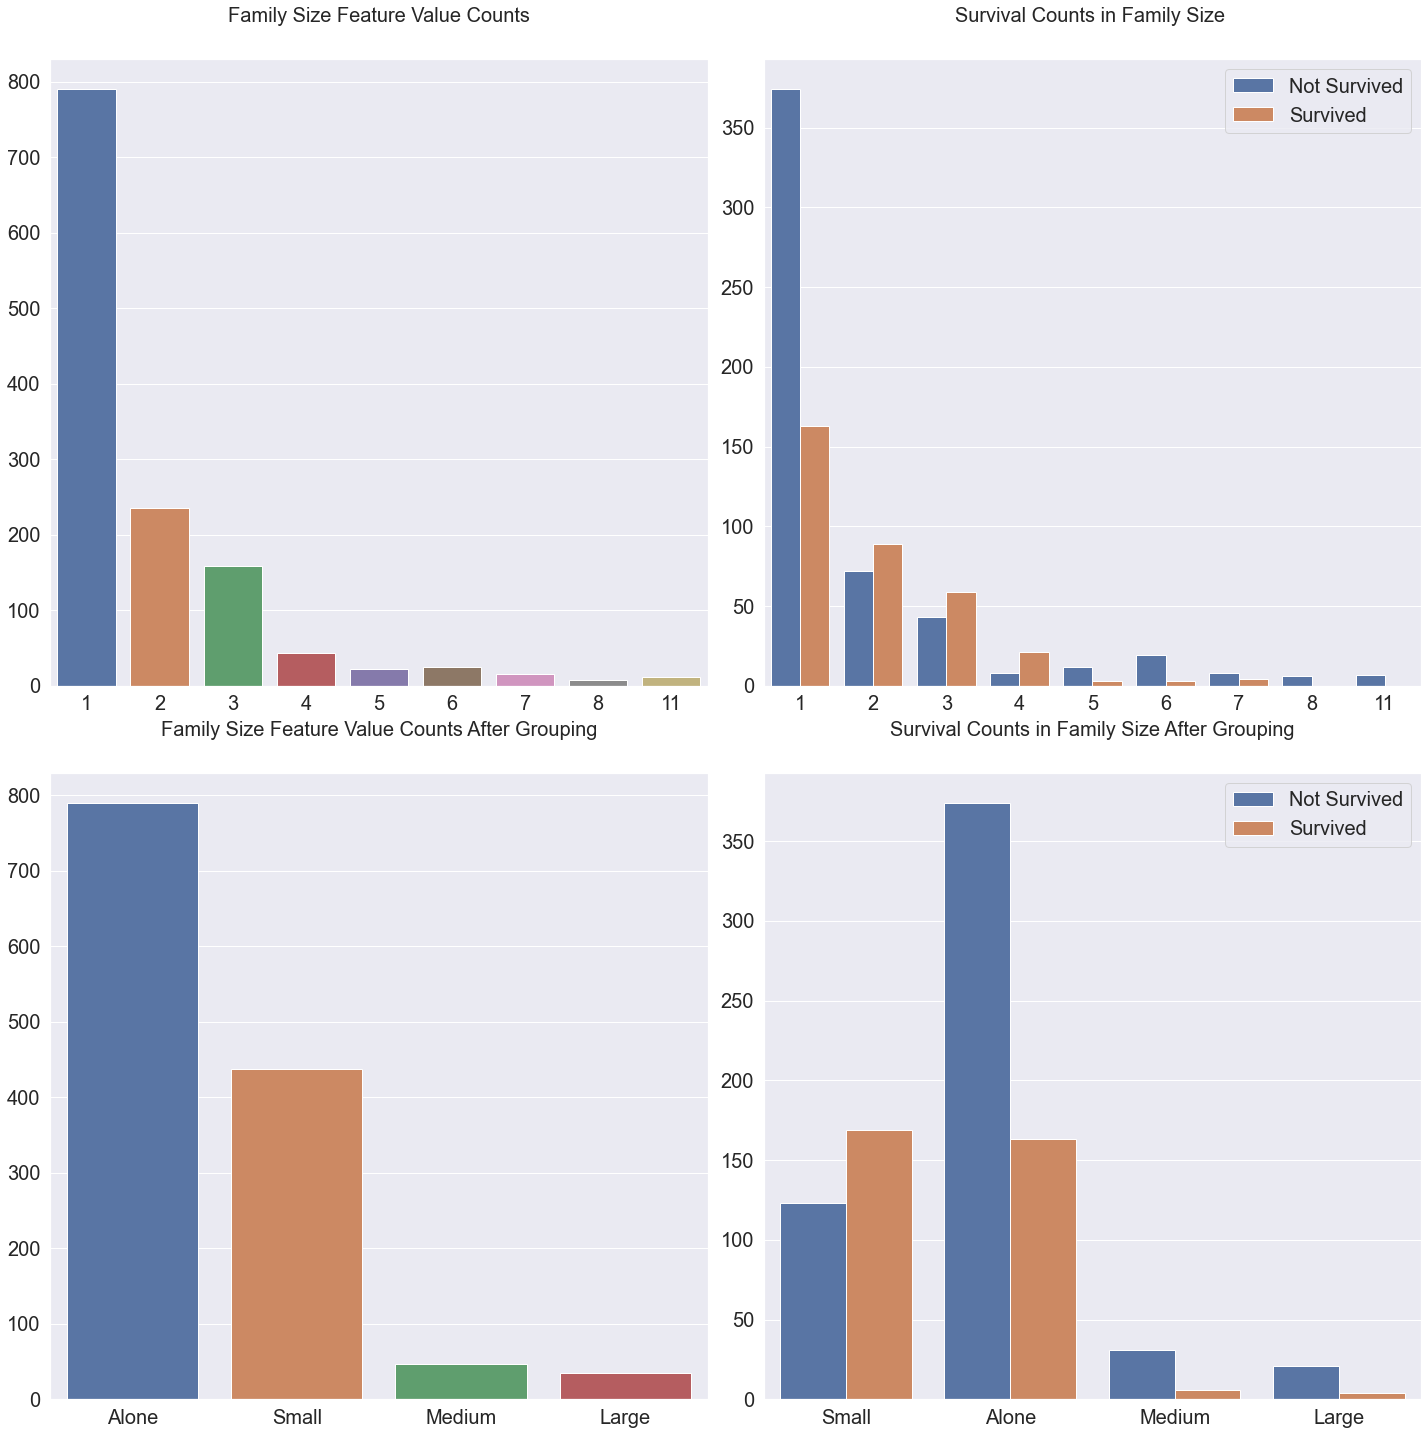

In [13]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all['Family_Size'].value_counts().index,
            y=df_all['Family_Size'].value_counts().values,
            ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=df_all, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {
    1: 'Alone',
    2: 'Small',
    3: 'Small',
    4: 'Small',
    5: 'Medium',
    6: 'Medium',
    7: 'Large',
    8: 'Large',
    11: 'Large'
}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

sns.barplot(x=df_all['Family_Size_Grouped'].value_counts().index,
            y=df_all['Family_Size_Grouped'].value_counts().values,
            ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped',
              hue='Survived',
              data=df_all,
              ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping',
                    size=20,
                    y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping',
                    size=20,
                    y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'],
                     loc='upper right',
                     prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')
plt.tight_layout()
plt.show()

Pada plot menjelaskan bahwa orang dengan Family_Size 2,3,4 mempunyai kemungkinan selamat lebih besar, selebihnya kemungkinannya menurun dan orang yang pergi dengan Family_Size_Grouped Small lebih terlihat mempunyai tingkat keselamatan lebih besar.

### Feature Engineering - Part 2
Kita buat feature baru bernama Ticket_Frequency dengan nilai gabungan dari Ticket yang sama. Contoh sebelumnya akan bernilai 6, karena ada 6 ticket yang sama dalam data kita.

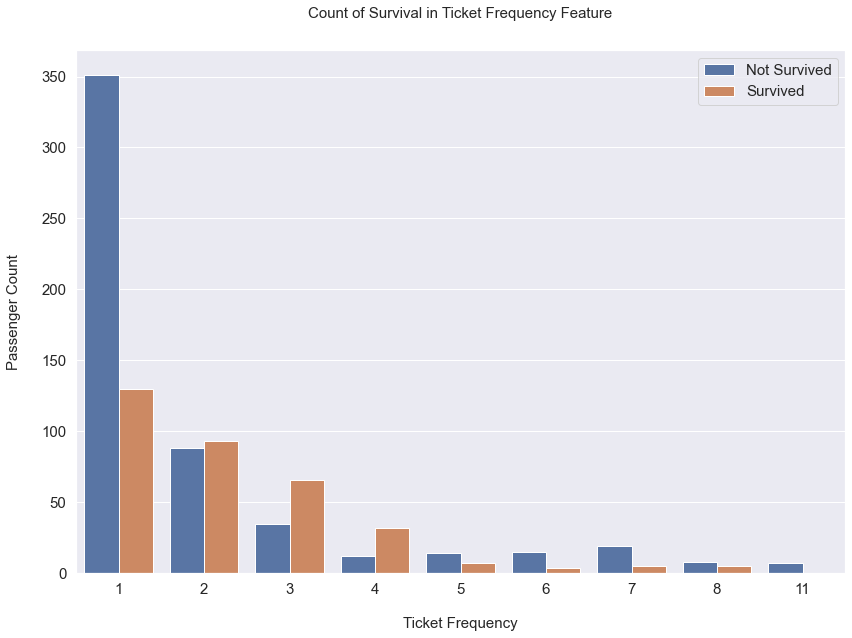

In [14]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform(
    'count')

fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=df_all)

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'),
          size=15,
          y=1.05)
plt.tight_layout()
plt.show()

Pada hasil plot penjelasannya feature Family_Size_Grouped, di angka 2,3,4 kemungkinan tingkat selamatnya meningkat.

Kenapa feature ini berbeda dari Family_Size_Grouped? Karena bisa jadi ada pembantu, teman yang menggunakan tiket yang sama tetapi tidak terhitung sebagai keluarga.

### Feature Engineering - Part 3
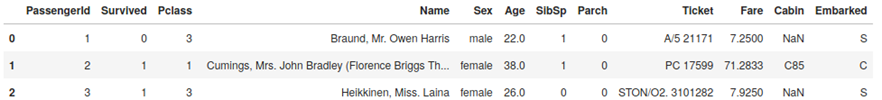
Jika anda lihat pada contoh di atas, dari nama orang yang ada di dataset ini, semuanya mempunyai pola yang sama, yaitu:<br>
<b>[Nama_belakang], [Jabatan]. [Nama_depan]</b>

sehingga kita bisa mengambil jabatannya saja dengan mengambil kata setelah "," (koma) dan sebelum "." (titik).

In [15]:
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split(
    '.', expand=True)[0]

df_all['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [16]:
df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

C:\Users\numbe\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Feature Engineering - Part 4

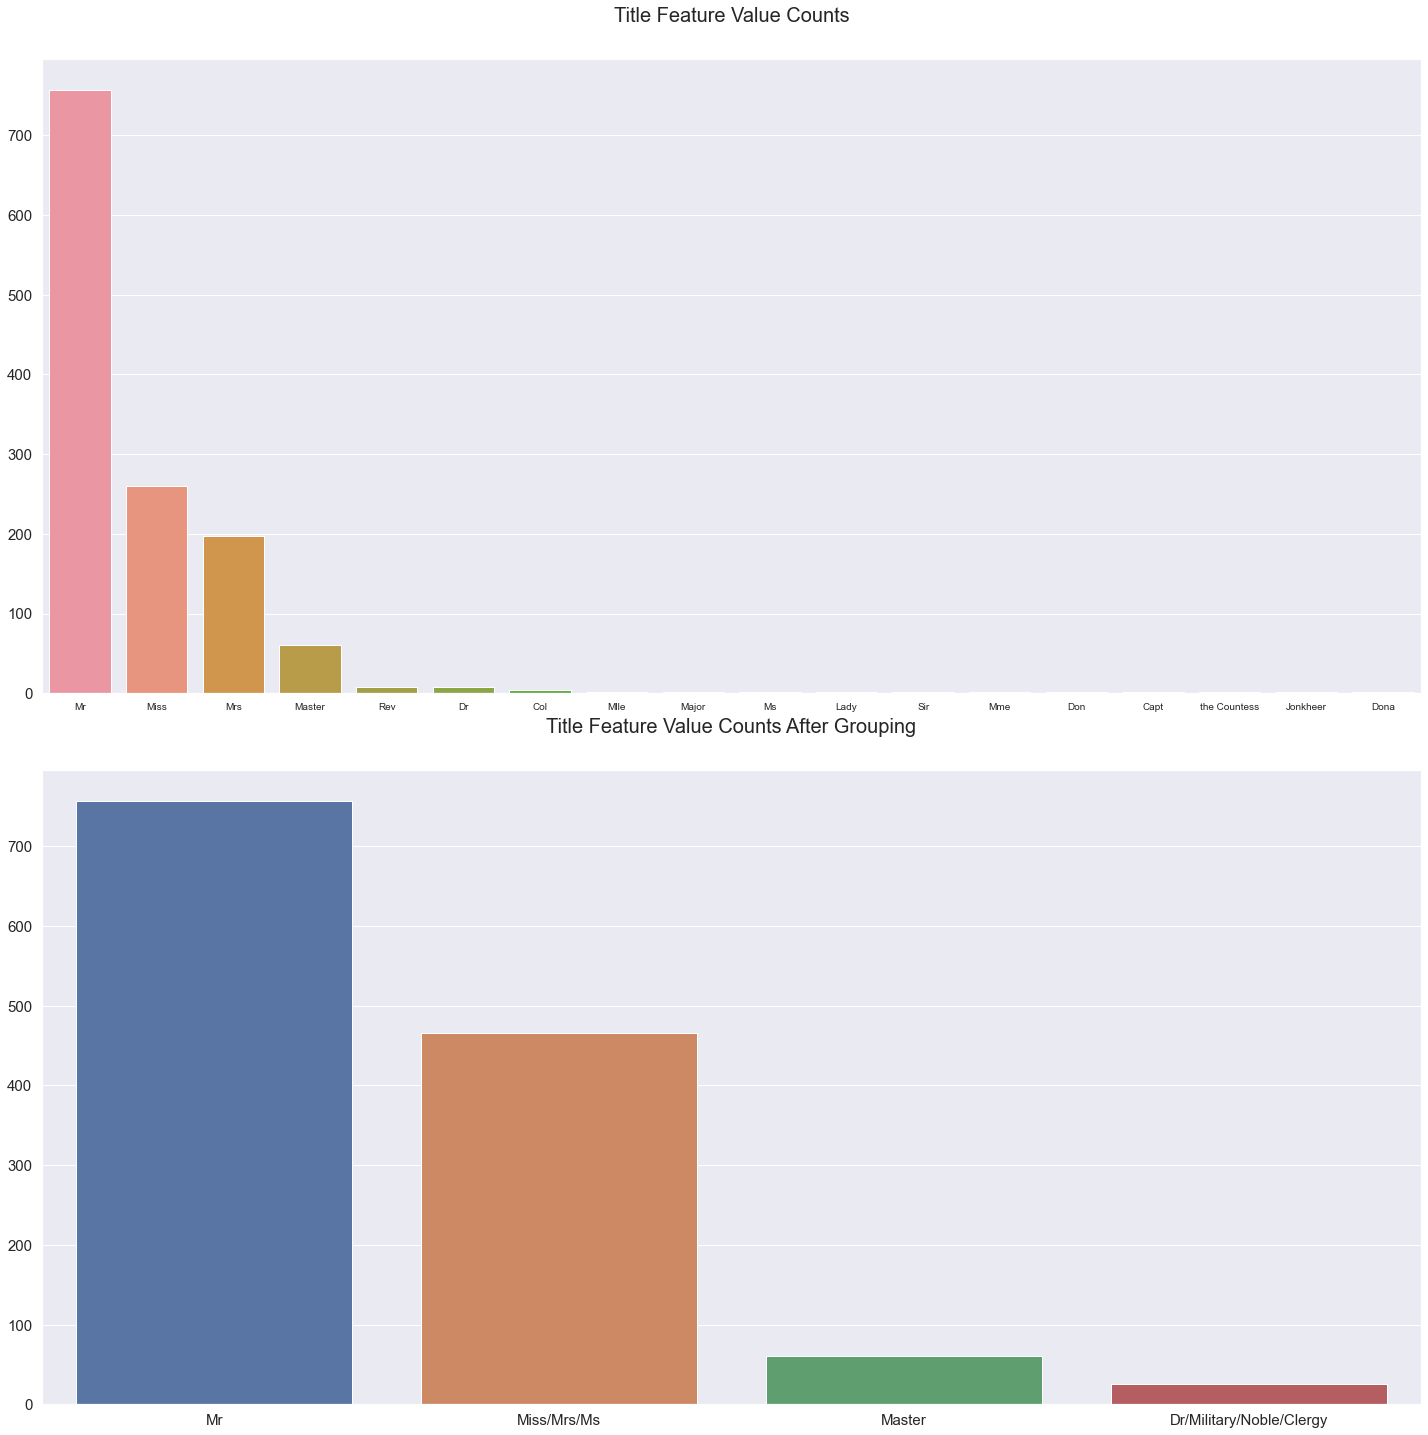

In [17]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.barplot(x=df_all['Title'].value_counts().index,
            y=df_all['Title'].value_counts().values,
            ax=axs[0])

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):
    axs[i].tick_params(axis='y', labelsize=15)

axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

df_all['Title'] = df_all['Title'].replace(
    ['Miss', 'Mrs', 'Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'],
    'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(
    ['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'],
    'Dr/Military/Noble/Clergy')

sns.barplot(x=df_all['Title'].value_counts().index,
            y=df_all['Title'].value_counts().values,
            ax=axs[1])
axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)
plt.tight_layout()
plt.show()

### Final Check

In [18]:
df_all.head()

Age Cabin Embarked              Fare  \
0  22.0   NaN        S    (-0.001, 7.25]   
1  38.0   C85        C  (56.496, 83.475]   
2  26.0   NaN        S     (7.896, 8.05]   
3  35.0  C123        S  (34.075, 56.496]   
4  35.0   NaN        S     (7.896, 8.05]   

                                                Name  Parch  PassengerId  \
0                            Braund, Mr. Owen Harris      0            1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...      0            2   
2                             Heikkinen, Miss. Laina      0            3   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)      0            4   
4                           Allen, Mr. William Henry      0            5   

   Pclass     Sex  SibSp  Survived            Ticket  Family_Size  \
0       3    male      1       0.0         A/5 21171            2   
1       1  female      1       1.0          PC 17599            2   
2       3  female      0       1.0  STON/O2. 3101282            1   
3       1  female      1       1.0            113803            2   
4       3    male      0       0.0            373450            1   

  Family_Size_Grouped  Ticket_Frequency        Title  Is_Married  
0               Small                 1           Mr           0  
1               Small                 2  Miss/Mrs/Ms           1  
2               Alone                 1  Miss/Mrs/Ms           0  
3               Small                 2  Miss/Mrs/Ms           1  
4               Alone                 1           Mr           0

### Modelling dengan hasil Feature Engineering - Part 1

In [19]:
#  membagi kembali dataset kita menjadi train dan test
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]

# LabelEncoder untuk data” yang bersifat non-numeric, tujuannya adalah melakukan encoding [0-n] untuk data kategorikal. Contohnya Sex, akan dirubah menjadi 0 dan 1, laki-laki dan perempuan.
non_numeric_features = [
    'Embarked', 'Sex', 'Title', 'Family_Size_Grouped', 'Age', 'Fare'
]

for df in dfs:
    for feature in non_numeric_features:
        df[feature] = LabelEncoder().fit_transform(df[feature])

# mengubah feature kategori menjadi one hot, dengan OneHotEncoder. Akan menghasilkan beberapa kolom tergantung banyaknya kategori.
# Contohnya Pclass akan menjadi 3 kolom Pclass_1, Pclass_2, dan Pclass_3. Isinya adalah 0 dan 1 tergantung kategori orang tersebut
cat_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(
            df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:5]], axis=1)
df_test = pd.concat([df_test, *encoded_features[5:]], axis=1)

C:\Users\numbe\AppData\Local\Temp/ipykernel_11376/1315013387.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = LabelEncoder().fit_transform(df[feature])


### Modelling dengan hasil Feature Engineering - Part 2
Kita akan melakukan drop terhadap kolom-kolom yang tidak kita perlukan, atau yang sudah kita encode sebelumnya.

In [20]:
df_all = concat_df(df_train, df_test)
drop_cols = [
    'Cabin', 'Embarked', 'Family_Size', 'Family_Size_Grouped', 'Survived',
    'Name', 'PassengerId', 'Pclass', 'Sex', 'Ticket', 'Title'
]

df_all.drop(columns=drop_cols, inplace=True)

df_all.head()

Age  Embarked_1  Embarked_2  Embarked_3  Family_Size_Grouped_1  \
0   28         0.0         0.0         1.0                    0.0   
1   52         1.0         0.0         0.0                    0.0   
2   34         0.0         0.0         1.0                    1.0   
3   48         0.0         0.0         1.0                    0.0   
4   48         0.0         0.0         1.0                    1.0   

   Family_Size_Grouped_2  Family_Size_Grouped_3  Family_Size_Grouped_4  Fare  \
0                    0.0                    0.0                    1.0     0   
1                    0.0                    0.0                    1.0    11   
2                    0.0                    0.0                    0.0     3   
3                    0.0                    0.0                    1.0    10   
4                    0.0                    0.0                    0.0     3   

   Is_Married  ...  Pclass_2  Pclass_3  Sex_1  Sex_2  SibSp  Ticket_Frequency  \
0           0  ...       0.0       1.0    0.0    1.0      1                 1   
1           1  ...       0.0       0.0    1.0    0.0      1                 2   
2           0  ...       0.0       1.0    1.0    0.0      0                 1   
3           1  ...       0.0       0.0    1.0    0.0      1                 2   
4           0  ...       0.0       1.0    0.0    1.0      0                 1   

   Title_1  Title_2  Title_3  Title_4  
0      0.0      0.0      0.0      1.0  
1      0.0      0.0      1.0      0.0  
2      0.0      0.0      1.0      0.0  
3      0.0      0.0      1.0      0.0  
4      0.0      0.0      0.0      1.0  

[5 rows x 22 columns]

### Modelling dengan hasil Feature Engineering - Part 3

In [21]:
X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 22)
y_train shape: (891,)
X_test shape: (418, 22)


### Modelling dengan hasil Feature Engineering - Part 4
Kita akan menggunakan RandomForestClassifier dari SkLearn dan menghitung akurasi menggunakan cross_val_score

In [22]:
random_forest = RandomForestClassifier(criterion='gini',
                                       n_estimators=1100,
                                       max_depth=5,
                                       min_samples_split=4,
                                       min_samples_leaf=5,
                                       max_features='auto',
                                       oob_score=True,
                                       random_state=50)
random_forest.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score

scores = cross_val_score(random_forest,
                         X_train,
                         y_train,
                         cv=10,
                         scoring="accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.83333333 0.87640449 0.76404494 0.87640449 0.84269663 0.80898876
 0.82022472 0.78651685 0.87640449 0.85393258]
Mean: 0.8338951310861423
Standard Deviation: 0.03719055862675359


Hasil akurasi nya dengan menggunakan feature dari feature engineering adalah sekitar 0.832

### Modelling tanpa hasil Feature Engineering - Part 1
Sekarang kita akan modelling lagi tanpa menyertakan fitur yang sudah kita buat.

In [23]:
df_all = concat_df(df_train, df_test)
drop_cols = [
    'Cabin', 'Embarked', 'Family_Size', 'Family_Size_Grouped', 'Survived',
    'Name', 'PassengerId', 'Pclass', 'Sex', 'Ticket', 'Title',
    'Family_Size_Grouped_1', 'Family_Size_Grouped_2', 'Family_Size_Grouped_3',
    'Family_Size_Grouped_4', 'Ticket_Frequency', 'Title_1', 'Title_2',
    'Title_3', 'Title_4', 'Is_Married'
]

df_all.drop(columns=drop_cols, inplace=True)

df_all.head()

Age  Embarked_1  Embarked_2  Embarked_3  Fare  Parch  Pclass_1  Pclass_2  \
0   28         0.0         0.0         1.0     0      0       0.0       0.0   
1   52         1.0         0.0         0.0    11      0       1.0       0.0   
2   34         0.0         0.0         1.0     3      0       0.0       0.0   
3   48         0.0         0.0         1.0    10      0       1.0       0.0   
4   48         0.0         0.0         1.0     3      0       0.0       0.0   

   Pclass_3  Sex_1  Sex_2  SibSp  
0       1.0    0.0    1.0      1  
1       0.0    1.0    0.0      1  
2       1.0    1.0    0.0      0  
3       0.0    1.0    0.0      1  
4       1.0    0.0    1.0      0

In [24]:
X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 12)
y_train shape: (891,)
X_test shape: (418, 12)


### Modelling tanpa hasil Feature Engineering - Part 2

In [25]:
random_forest = RandomForestClassifier(criterion='gini',
                                       n_estimators=1100,
                                       max_depth=5,
                                       min_samples_split=4,
                                       min_samples_leaf=5,
                                       max_features='auto',
                                       oob_score=True,
                                       random_state=50)
random_forest.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score

scores = cross_val_score(random_forest,
                         X_train,
                         y_train,
                         cv=10,
                         scoring="accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.78888889 0.84269663 0.76404494 0.87640449 0.85393258 0.80898876
 0.79775281 0.7752809  0.86516854 0.80898876]
Mean: 0.818214731585518
Standard Deviation: 0.03700330937285851


Akurasi meningkat sekitar 0.2 , artinya fitur yang kita buat dapat menaikkan 2% akurasi model. Ini adalah salah satu kegunaan dari Feature Engineering.

**Note**: Akurasi ini tidak absolut dan dapat berubah, tergantung dari banyak factor, termasuk dari parameter yang dimasukkan. Fitur yang kita buat pun dapat menjadi buruk juga tergantung tipe model yang digunakan.

### Kesimpulan
Hasil perbandingan dari 2 model tersebut seperti di bawah ini:
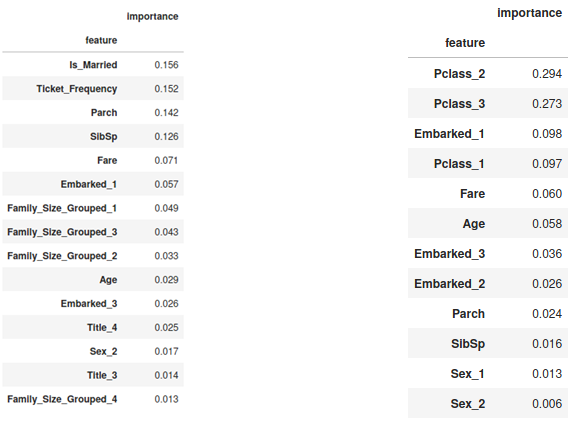

**Konklusi**:
Feature Engineering mengharuskan kita membuat banyak ide fitur dari data yang sudah ada.

Biasanya yang dapat kita lakukan adalah, penggabungan (grouping), ekstraksi fitur (seperti Title yang didapat dari nama orang), dan masih banyak lagi.

Jangan malas untuk melakukan feature engineering dan mencoba segala sesuatu yang ada di pikiran kita. Barangkali ini dapat meningkatkan akurasi model kita.